<ipython-input-9-b6360c08224e>:28: RuntimeWarning: invalid value encountered in true_divide
  abl_curve = np.true_divide(LOR.sum(0),(LOR!=0).sum(0))
<ipython-input-9-b6360c08224e>:28: RuntimeWarning: invalid value encountered in true_divide
  abl_curve = np.true_divide(LOR.sum(0),(LOR!=0).sum(0))
<ipython-input-9-b6360c08224e>:28: RuntimeWarning: invalid value encountered in true_divide
  abl_curve = np.true_divide(LOR.sum(0),(LOR!=0).sum(0))
<ipython-input-9-b6360c08224e>:28: RuntimeWarning: invalid value encountered in true_divide
  abl_curve = np.true_divide(LOR.sum(0),(LOR!=0).sum(0))
<ipython-input-9-b6360c08224e>:28: RuntimeWarning: invalid value encountered in true_divide
  abl_curve = np.true_divide(LOR.sum(0),(LOR!=0).sum(0))
<ipython-input-9-b6360c08224e>:28: RuntimeWarning: invalid value encountered in true_divide
  abl_curve = np.true_divide(LOR.sum(0),(LOR!=0).sum(0))
<ipython-input-9-b6360c08224e>:28: RuntimeWarning: invalid value encountered in true_divide
  abl_curve = 

ValueError: x and y must have same first dimension, but have shapes (101,) and (100,)

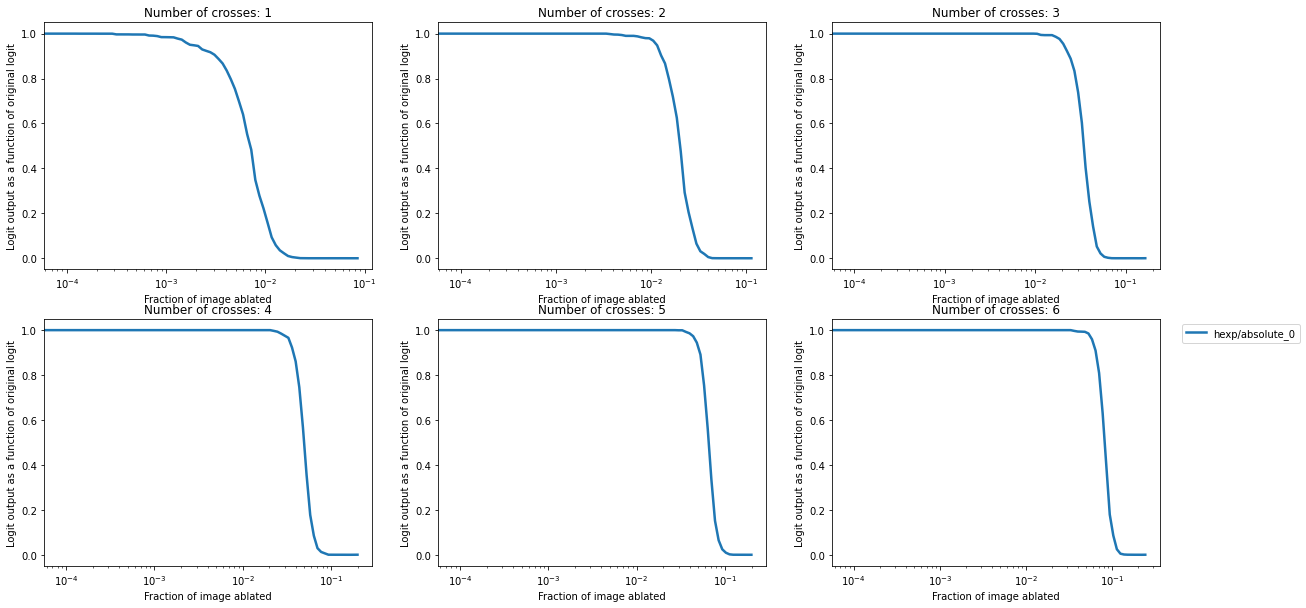

In [9]:
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn import metrics
import torch

# exp_x = np.linspace(-1, 0, 20)
# perturbation_sizes = np.sort(1.1 - 10 ** (exp_x))
A = 100*120
exp_x = np.linspace(np.log10(1/A), 0, 100)
relative_perturbation_sizes = np.concatenate(([0], np.sort(10 ** (exp_x))))
exp_mapper = ["hexp/absolute_0", "partexp", "gradexp", "deepexp", "gradcam", "gradcampp", "naive", "RDE", "lime"]

c = [1, 2, 3, 4, 5, 6]
fig = plt.figure(figsize=(20, 10))
axes = fig.subplots(int(len(c)/3) if len(c)%3 == 0 else int(len(c)/3) + 1, 3)
for exp_name in exp_mapper:
    for j, n in enumerate(c):
        LOR = np.load(os.path.join("LOR", "%s/results_%d.npy" % (exp_name, n)))
        drop = []
        # for i, p in enumerate(relative_perturbation_sizes):
        #     c = LOR[:, i]
        #     nonzero_ids = np.where(c != 0)
        #     nonzero_c = c[nonzero_ids]
        #     drop.append(np.median(nonzero_c))
        ax = axes[int(j/3), j%3]
        # ax.plot(relative_perturbation_sizes, np.mean(LOR, axis=0), label=exp_name)
        abl_curve = np.true_divide(LOR.sum(0),(LOR!=0).sum(0))
        ax.plot(relative_perturbation_sizes, abl_curve, label=exp_name, lw=2.5)
        # ax.plot(relative_perturbation_sizes, np.log10(6.6363e-04) * np.ones(len(relative_perturbation_sizes)), '-.k')    
        ax.set_xscale("log")
        ax.set_xlabel("Fraction of image ablated")
        ax.set_ylabel("Logit output as a function of original logit")
        ax.set_title("Number of crosses: %d" % n)
        if j == len(c)-1:
            ax.legend(bbox_to_anchor=(1.05, 1))      
plt.savefig("LOR.eps")

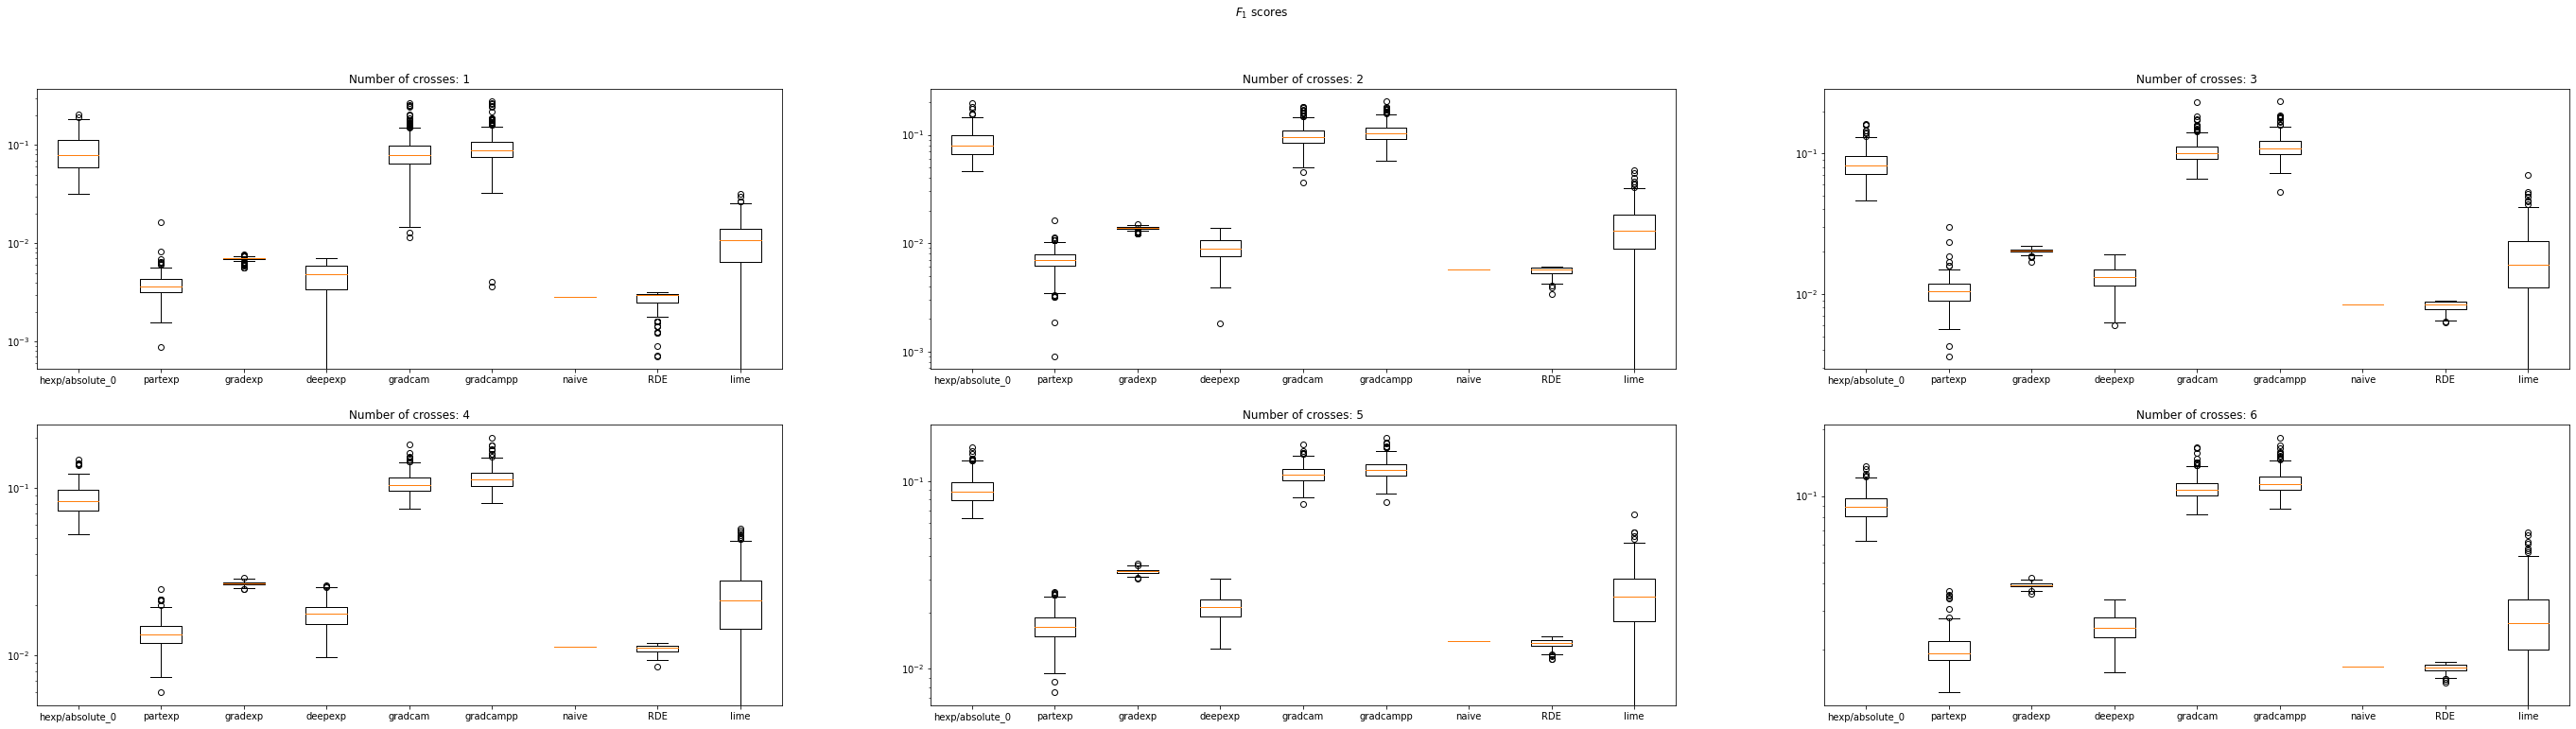

In [2]:
from PIL import Image

c = [1, 2, 3, 4, 5, 6]
true_positives = np.load("true_positives.npy", allow_pickle=True)

fig = plt.figure(figsize=(48, 12))
axes = fig.subplots(int(len(c)/3) if len(c)%3 == 0 else int(len(c)/3) + 1, 3)

for j, n in enumerate(c):
    data = []
    for exp_name in exp_mapper:
        explanation_dir = os.path.join("true_positive_explanations", exp_name)
        scores = []
        for i, image_path in enumerate(true_positives.item()[str(n)]):
            image = Image.open(image_path)
            # fig = plt.figure()
            # axes = fig.subplots(1, 2)
            # axes[0].imshow(image)
            image_name = os.path.basename(image_path)
            image_id = int(image_name.split("_")[1].split(".")[0])
            # print(image_name, image_id)
            ground_truth = np.zeros((100, 120))
            positions = np.load("/export/gaon1/data/jteneggi/data/synthetic/LOR/ground_truth/%d/ex%d_%d.npy" % (n, n, image_id))
            # print(positions)
            for position in positions:
                top_left = position[0]
                bottom_right = position[1]
                for k in range(9):
                    ground_truth[top_left[1]+k, top_left[0]+k] = 1
                    ground_truth[bottom_right[1]-k, top_left[0]+k] = 1
                # ground_truth[top_left[1]:bottom_right[1]+1, top_left[0]:bottom_right[0]+1] = 1
            # axes[0].imshow(ground_truth)
            if exp_name == "naive":
                explanation = torch.rand(100, 120, device=torch.device("cpu")) + .5
            else:
                explanation = np.load(os.path.join(explanation_dir, "%s.npy" % image_name))
            score = metrics.f1_score(ground_truth.flatten(), explanation.flatten() > 0)
            scores.append(score)
            # axes[1].imshow(explanation)
        data.append(scores)
    ax = axes[int(j/3), j%3]
    ax.boxplot(data, labels=exp_mapper)
    ax.set_yscale("log")
    ax.set_title("Number of crosses: %d" % n)
fig.suptitle(r"$F_1$ scores")
plt.savefig("f1_scores.eps")

In [3]:
from sklearn import metrics

truth = np.array([0, 0, 1])
pred = np.array([2, 3, 4]) >= 3
metrics.f1_score(truth, pred)

0.6666666666666666

In [4]:
LOR = np.load(os.path.join("LOR", "%s/results_%d.npy" % ("hexp/absolute_0", 2)))
print(LOR[:, 70])

[6.96428879e-06 1.42096382e-04 7.36169598e-11 0.00000000e+00
 4.57278111e-06 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.30823910e-05 8.03886024e-08 0.00000000e+00 8.94928220e-09
 1.16915317e-05 8.23311475e-10 2.63295150e-11 0.00000000e+00
 4.02303328e-08 8.03898613e-04 4.16908588e-04 1.08633885e-05
 0.00000000e+00 6.96956849e-05 0.00000000e+00 5.23771521e-12
 1.12818896e-06 4.64415731e-04 7.55533483e-06 1.34624104e-04
 4.06519903e-05 1.38861492e-10 0.00000000e+00 0.00000000e+00
 8.50444212e-06 0.00000000e+00 0.00000000e+00 2.05648166e-06
 7.50584644e-04 5.89320015e-09 0.00000000e+00 0.00000000e+00
 4.62130594e-12 0.00000000e+00 0.00000000e+00 0.00000000e+00
 8.98819952e-09 3.15163312e-11 9.81846809e-12 5.16604749e-04
 1.03837727e-14 5.16315392e-16 2.42541919e-05 3.49474503e-05
 0.00000000e+00 2.26349869e-07 6.63625775e-04 6.63625775e-04
 5.21612645e-04 0.00000000e+00 2.79111409e-04 0.00000000e+00
 0.00000000e+00 7.08794516e-07 0.00000000e+00 4.64595202e-03
 6.65364263e-04 4.162861